In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import ast

from src.wimbd_ import BasePaths as PATHS, Colors
from src.wimbd_ import DataConfigs as CONFIG
from src.wimbd_ import post_filter, filter_percentile, load_results
from src.wimbd_ import ProcessTriviaQA as ptqa
from src.utils import remove_nested_lists, softmax
from src.analysis import AnalyzeNgrams as an

from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Generate a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[dynet] random seed: 1234
[dynet] allocating memory: 32MB
[dynet] memory allocation done.


In [2]:
task_coverage_pth = "./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/3/common/task-p-coverage.pkl"
task_coverage = pd.read_pickle(task_coverage_pth)

In [3]:
all_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']
large_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b']
small_models = ['pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']

N_GRAMS = 5
ALIGN_THRESH = 90
# BASE_DIR = f"./results/n-grams/trivia_qa/pile/exp_3/test-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/"
# BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse"
# BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse"
DATASET = "examples_dfs_0-shot_common_post-processed-aligned.pkl" # "examples_dfs_4-shot_common_models.pkl"
TASKS = "mmlu"
CORPUS = "pile"
BASE_DIR = PATHS.base_ngram_paths[TASKS][CORPUS]['base_path']
OMMIT_TASKS = False
TASKS_OMMIT = ["formal_logic"]
POST_FILTER = True

# BASE_DIR = PATHS.base_ngram_paths[TASKS]['base_path']
BASE_PATH = os.path.join(BASE_DIR, f"{N_GRAMS}")
METHOD = "0-shot_common"
BASE_PATH_COMMON = os.path.join(BASE_PATH, "common")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
# FIG_DIR = os.path.join("/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/figures", DATASET, timestamp)
# if not os.path.exists(FIG_DIR):
#     os.makedirs(FIG_DIR)

# RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), 'common', DATASET)
RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), DATASET)
FIGS_PTH = f"./figures/{TASKS}"

# SUB_TASKS = ['marketing', 'management', 
#              'high_school_world_history',
#              'high_school_european_history',
#              'miscellaneous']

SUB_TASKS = ['public_relations', 'miscellaneous', 'nutrition', 'management',
            'conceptual_physics', 'professional_psychology',
            'high_school_us_history', 'high_school_psychology',
            'high_school_geography', 'high_school_world_history',
            'human_aging', 'high_school_european_history', 'virology',
            'anatomy', 'astronomy', 'computer_security', 'marketing',
            'logical_fallacies', 'international_law']

# SUB_TASKS = ['marketing',
#              'high_school_world_history',
#              'miscellaneous']

MODELS = 'open-instruct-pythia-6.9b-tulu'



print(f"BASE PATH: {BASE_PATH}")

VIEW_COLS = ['Q', 'A', 'question', 'value', 'align_score', 'em', 'answer']

BASE PATH: ./results/n-grams/mmlu/exp3/test-set/exp_full_None/5


In [30]:
RESULTS_PATH

'./results/n-grams/mmlu/exp3/test-set/exp_full_None/5/examples_dfs_0-shot_common_post-processed-aligned.pkl'

In [4]:
# filter outliers
pickle_file = pd.read_pickle(RESULTS_PATH)
# df = pd.DataFrame(pickle_file).T.sort_values("value", ascending=False)

# filter
# open
# examples_models_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl")
examples_models_pth = RESULTS_PATH
if os.path.exists(examples_models_pth):
    with open(examples_models_pth, 'rb') as f:
        examples_models = pickle.load(f)
else:
    examples_models = ptqa.process_model_examples(pickle_file, p=0.99999)
examples_model = examples_models['open-instruct-pythia-6.9b-tulu']
colors = sns.color_palette('hls', len(examples_models))

In [5]:
examples_model.head()

,Q,A,value,example,task,pair,coverage,question,alignment_score,query,sum,count,id,gold,query_drop,choices,gold_drop,result,accuracy
1,objective,Broad,603129,{'question': 'Which of these should an objecti...,public_relations,"(objective, Broad)",0.001609,Which of these should an objective NOT be?,80.191338,Which of these should an objective NOT be?,812800,4,106_17,0,Which of these should an objective NOT be?\nA....,"[A, B, C, D]",0,"[-2.060636043548584, -1.0321813821792603, -1.3...",0
4,virus,Chicken pox,8794,"{'question': 'Which of these is a virus?', 'ch...",miscellaneous,"('virus', 'Chicken pox')",0.025744,Which of these is a virus?,86.200790,Which of these is a virus?,166595,4,26_14,0,Which of these is a virus?\nA. Staphylococcus\...,"[A, B, C, D]",3,"[-1.171823501586914, -1.3485488891601562, -1.8...",0
11,histones,Proteins,62656,"{'question': 'What are histones? ', 'choices':...",nutrition,"(histones, Proteins)",0.007558,What are histones?\n,90.503082,What are histones?\n,80543,4,232_15,0,What are histones?\nA. Lipids\nB. Carbohydrate...,"[A, B, C, D]",3,"[-3.0945048332214355, -2.4091334342956543, -0....",0
13,spice,cucumber,29739,"{'question': 'Which of these is not a spice?',...",miscellaneous,"('spice', 'cucumber')",0.025744,Which of these is not a spice?,82.105064,Which of these is not a spice?,78161,4,563_14,0,Which of these is not a spice?\nA. dill\nB. an...,"[A, B, C, D]",2,"[-2.097806453704834, -1.0631023645401, -1.3930...",0
16,legumes,radishes,5418,{'question': 'Which of these are not legumes?'...,miscellaneous,"('legumes', 'radishes')",0.025744,Which of these are not legumes?,81.906601,Which of these are not legumes?,73517,4,359_14,0,Which of these are not legumes?\nA. beans\nB. ...,"[A, B, C, D]",2,"[-0.9904704093933105, -1.4415812492370605, -1....",0


In [6]:
def filter_correct_choices(df):
    def is_correct_choice(row):
        example = row['example']
        if isinstance(example, str):
            example = ast.literal_eval(example)
        choices = example['choices']
        answer_index = example['answer']
        correct_answer = choices[answer_index]
        return row['A'] == correct_answer
    
    filtered_df = df[df.progress_apply(is_correct_choice, axis=1)]
    return filtered_df

def add_accuracy_column(df):
    def is_correct_answer(row):
        example = row['example']
        if isinstance(example, str):
            example = ast.literal_eval(example)
        answer_index = example['answer']
        result = row['result']
        if isinstance(result, str):
            result = ast.literal_eval(result)
        predicted_index = np.argmax(result)
        return int(predicted_index == answer_index)

    df['accuracy'] = df.progress_apply(is_correct_answer, axis=1)
    return df

examples_models = {MODELS: examples_models[MODELS]}
# examples_models = {task: examples_models[examples_models['task'] == task] for task in examples_models['task'].unique() if task in SUB_TASKS}
examples_models = {k: filter_correct_choices(v) for k, v in examples_models.items()}
examples_models = {k: add_accuracy_column(v) for k, v in examples_models.items()}

# # save 
# examples_models_correct_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl")
# with open(examples_models_correct_pth, 'wb') as f:
#     pickle.dump(examples_models, f)

100%|██████████| 87825/87825 [00:03<00:00, 25779.68it/s]


In [7]:
# from src.wimbd_ import align_e5_pairs_df

# examples_models = {k: align_e5_pairs_df(df, 'Q', 'question') for k, df in examples_models.items()}

# # save
# examples_models_correct_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed-aligned.pkl")
# with open(examples_models_correct_pth, 'wb') as f:
#     pickle.dump(examples_models, f)

In [8]:
# # save
# with open(os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl"), 'wb') as f:
#     pickle.dump(examples_models, f)

In [9]:
examples_models['open-instruct-pythia-6.9b-tulu'].head()

,Q,A,value,example,task,pair,coverage,question,alignment_score,query,sum,count,id,gold,query_drop,choices,gold_drop,result,accuracy
1,objective,Broad,603129,{'question': 'Which of these should an objecti...,public_relations,"(objective, Broad)",0.001609,Which of these should an objective NOT be?,80.191338,Which of these should an objective NOT be?,812800,4,106_17,0,Which of these should an objective NOT be?\nA....,"[A, B, C, D]",0,"[-2.060636043548584, -1.0321813821792603, -1.3...",0
4,virus,Chicken pox,8794,"{'question': 'Which of these is a virus?', 'ch...",miscellaneous,"('virus', 'Chicken pox')",0.025744,Which of these is a virus?,86.200790,Which of these is a virus?,166595,4,26_14,0,Which of these is a virus?\nA. Staphylococcus\...,"[A, B, C, D]",3,"[-1.171823501586914, -1.3485488891601562, -1.8...",0
11,histones,Proteins,62656,"{'question': 'What are histones? ', 'choices':...",nutrition,"(histones, Proteins)",0.007558,What are histones?\n,90.503082,What are histones?\n,80543,4,232_15,0,What are histones?\nA. Lipids\nB. Carbohydrate...,"[A, B, C, D]",3,"[-3.0945048332214355, -2.4091334342956543, -0....",0
13,spice,cucumber,29739,"{'question': 'Which of these is not a spice?',...",miscellaneous,"('spice', 'cucumber')",0.025744,Which of these is not a spice?,82.105064,Which of these is not a spice?,78161,4,563_14,0,Which of these is not a spice?\nA. dill\nB. an...,"[A, B, C, D]",2,"[-2.097806453704834, -1.0631023645401, -1.3930...",0
16,legumes,radishes,5418,{'question': 'Which of these are not legumes?'...,miscellaneous,"('legumes', 'radishes')",0.025744,Which of these are not legumes?,81.906601,Which of these are not legumes?,73517,4,359_14,0,Which of these are not legumes?\nA. beans\nB. ...,"[A, B, C, D]",2,"[-0.9904704093933105, -1.4415812492370605, -1....",0


In [10]:
examples_models_ = {model: data[data['alignment_score'] > ALIGN_THRESH] for model, data in examples_models.items()}

In [11]:
from src.analysis import AnalyzeNgrams as an

# coverage_path = os.path.join(BASE_PATH_COMMON, "task-coverage.pkl")
# task_cov = an.calculate_average_task_coverage(BASE_PATH_ALL, [TASKS], [N_GRAMS])

In [12]:
ALIGN_THRESH = 80
examples_models_ = {model: data[data['alignment_score'] > ALIGN_THRESH] for model, data in examples_models.items()}
# examples_models_['high_school_european_history'].head(20)

In [13]:
examples_models_tasks = {task: examples_models_['open-instruct-pythia-6.9b-tulu'][examples_models_['open-instruct-pythia-6.9b-tulu']['task'] == task] for task in examples_models_['open-instruct-pythia-6.9b-tulu']['task'].unique()}

In [25]:
# Define the colormap for languages
country_colors = {
    'fr-en': '#0055A4',   # France - Blue
    'es-en': '#FF9900',   # Spain - Orange
    'it-en': '#008C45',   # Italy - Green
    'de-en': '#FFCC00',   # Germany - Yellow
    'cs-en': '#D7141A',   # Czech Republic - Red
    'hu-en': '#8B4513'    # Hungary - SaddleBrown
}

subjects = [
    "human_aging",
    "high_school_world_history",
    "high_school_geography",
    "high_school_psychology",
    "nutrition",
    "marketing",
    "computer_security",
    "conceptual_physics"
]

subjects = [
    "human_aging",
    "high_school_world_history",
    "high_school_geography",
    "high_school_psychology",
    "nutrition",
    "marketing",
    "computer_security",
    "conceptual_physics"
]

# Create a colormap for subjects, matching the style of the previous colormap
subject_colors = {
    'human_aging': country_colors['fr-en'],
    'high_school_world_history': country_colors['es-en'],
    'high_school_geography': country_colors['it-en'],
    'high_school_psychology': country_colors['de-en'],
    'nutrition': country_colors['cs-en'],
    'marketing': country_colors['hu-en'],
    'computer_security': "#02c9c6",
    'conceptual_physics': "#c4167f"
}

name: public_relations
name: miscellaneous
name: nutrition
interval
[-1.0000, 1.6000)     1261
[1.6000, 4.2000)         3
[25, ∞)                  2
[19.8000, 22.4000)       1
[6.8000, 9.4000)         1
Name: count, dtype: int64
avg_df =                     interval_start     avg_y
interval                                    
[-1.0000, 1.6000)              1.0  0.300555
[1.6000, 4.2000)               1.6  0.333333
[6.8000, 9.4000)               6.8  0.000000
[19.8000, 22.4000)            19.8  1.000000
[25, ∞)                       25.0  0.500000
avg_y: interval
[-1.0000, 1.6000)     0.300555
[1.6000, 4.2000)      0.333333
[6.8000, 9.4000)      0.000000
[19.8000, 22.4000)    1.000000
[25, ∞)               0.500000
Name: avg_y, dtype: float64
Saved figure in ./figures/mmlu/avg_em_by_log_interval_all_logFalse_value_aligned80.pdf
name: management
name: conceptual_physics
interval
[-1.0000, 1.6000)     819
[25, ∞)                 5
[1.6000, 4.2000)        3
[12.0000, 14.6000)      2
[22.40

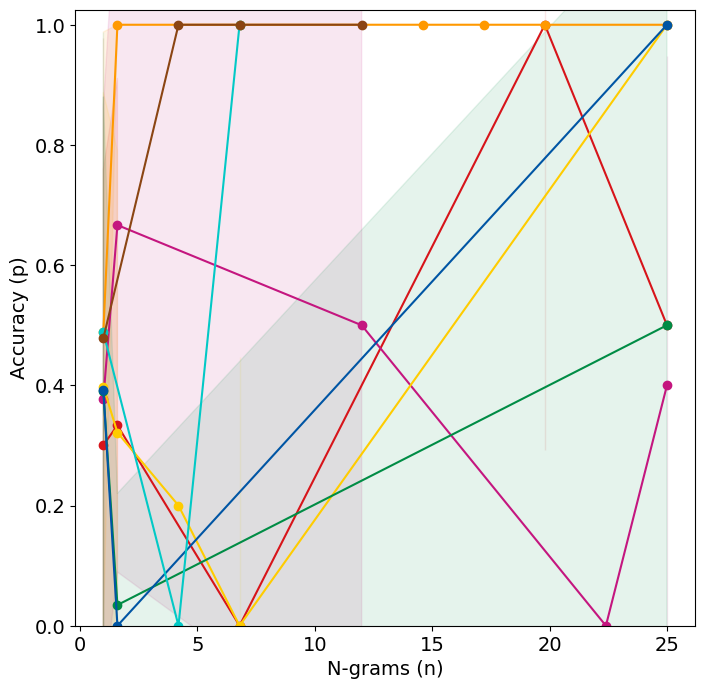

In [27]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# color_palette = sns.color_palette('husl', len(examples_models))
color_palette = sns.color_palette('Set2', len(examples_models_tasks))
# color_palette = plt.get_cmap('viridis', len(examples_models_))
# color_palette = [color_palette(i) for i in range(len(examples_models_))]
color_palette = [subject_colors[task] for task in subjects]

is_log = False
plot_var = 'value'
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")
for i, (model_name, data) in enumerate(examples_models_tasks.items()):
    print(f"name: {model_name}")
    if model_name not in subjects:
        continue
    data = an.create_bins(data, plot_var, -1, 25, 10, is_log)
    # data = ptqa.get_random_samples_by_interval(data, 85)
    ax = ptqa.plot_variable_by_interval(data, log_axis=is_log,
                                        x_column='interval', y_column='accuracy',
                                        save_pth=savefile, ax=ax, 
                                        color=subject_colors[model_name], label=model_name,
                                        #  title=f'Performance vs. Ngrams for Different Models, {TASKS}, N={N_GRAMS}',
                                        plot_std=True, ylimits=[0,1.025])

In [16]:
SUB_TASKS = ['public_relations', 'miscellaneous', 'nutrition', 'management',
            'conceptual_physics', 'professional_psychology',
            'high_school_us_history', 'high_school_psychology',
            'high_school_geography', 'high_school_world_history',
            'human_aging', 'high_school_european_history', 'virology',
            'anatomy', 'astronomy', 'computer_security', 'marketing',
            'logical_fallacies', 'international_law']

name: public_relations
name: miscellaneous
name: nutrition
interval
[-1.0000, 1.1000)    1261
[20, ∞)                 3
[1.1000, 3.2000)        3
[7.4000, 9.5000)        1
Name: count, dtype: int64
avg_df =                    interval_start     avg_y
interval                                   
[-1.0000, 1.1000)             1.0  0.300555
[1.1000, 3.2000)              1.1  0.333333
[7.4000, 9.5000)              7.4  0.000000
[20, ∞)                      20.0  0.666667
avg_y: interval
[-1.0000, 1.1000)    0.300555
[1.1000, 3.2000)     0.333333
[7.4000, 9.5000)     0.000000
[20, ∞)              0.666667
Name: avg_y, dtype: float64
Saved figure in ./figures/mmlu/avg_em_by_log_interval_all_logFalse_value_aligned80.pdf
name: management
name: conceptual_physics
interval
[-1.0000, 1.1000)     819
[20, ∞)                 6
[1.1000, 3.2000)        2
[11.6000, 13.7000)      2
[3.2000, 5.3000)        1
Name: count, dtype: int64
avg_df =                     interval_start     avg_y
interval         

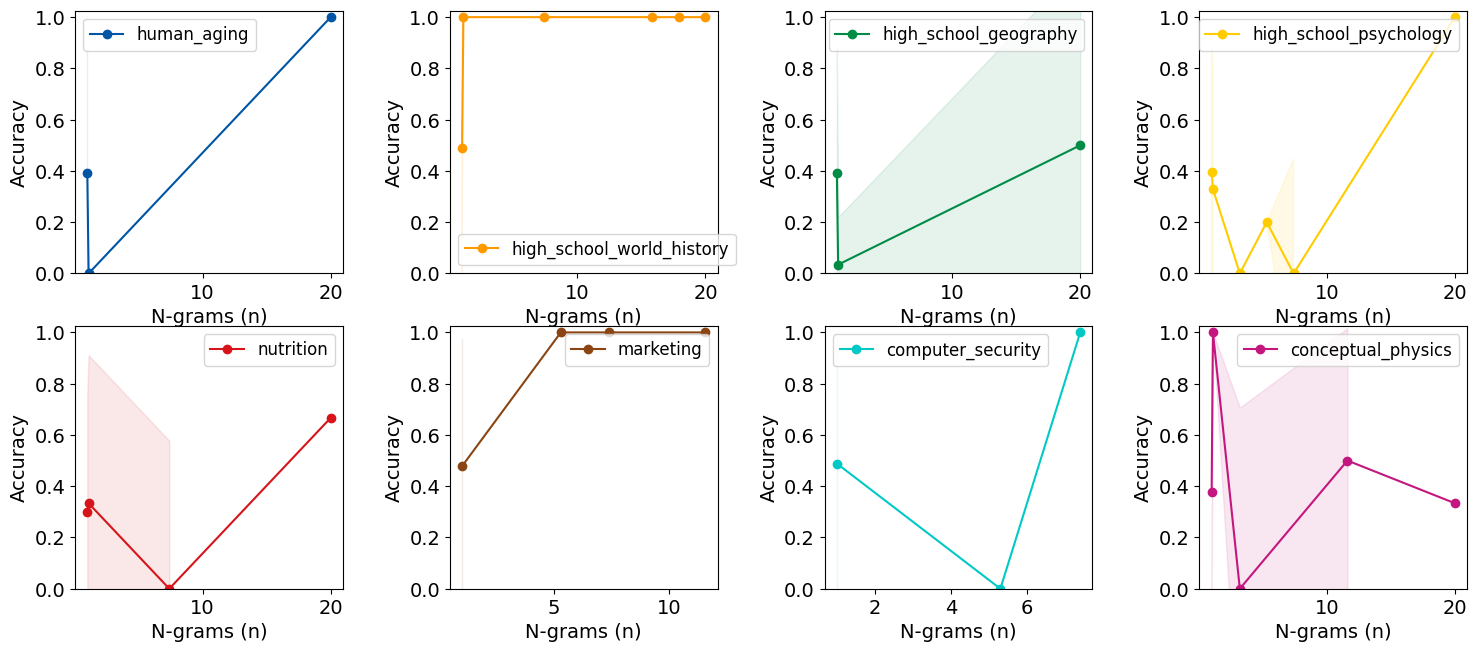

Saved figure to ./figures/mmlu/avg_em_by_log_interval_all_logFalse_value_aligned80.pdf


In [29]:
# Define color palette
color_palette = sns.color_palette('Set2', len(examples_models_tasks))

is_log = False
plot_var = 'value'
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")

# Create subplots
scale = 3
nrows = 2  # Adjust based on the number of subjects
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * scale, 2.25 * scale))
axs = axs.flatten()

for i, (model_name, data) in enumerate(examples_models_tasks.items()):
    print(f"name: {model_name}")
    
    if model_name not in subjects:
        continue
    
    # Calculate percentiles
    # data['percentile'] = data[plot_var].rank(pct=True) * 100
    # data['value'] = data[plot_var] / data[plot_var].sum()

    # Create bins based on percentiles
    data = an.create_bins(data, 'value', -1, 20, 10, is_log)
    
    # Plot the data using the new column for the x-axis
    ax = axs[subjects.index(model_name)]
    ptqa.plot_variable_by_interval(data, log_axis=is_log,
                                   x_column='interval', y_column='accuracy',
                                   save_pth=savefile, ax=ax, 
                                   color=subject_colors[model_name], label=model_name,
                                   plot_std=True, ylimits=[0, 1.025])
    # ax.set_title(model_name)
    # ax.set_xlabel('Percentile')
    ax.set_ylabel('Accuracy')
    ax.legend(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.4)  # Adjust the space between subplots
fig_save_pth = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")
plt.savefig(fig_save_pth)
plt.show()
print(f"Saved figure to {fig_save_pth}")

name: public_relations
interval
[-1.0000, 1.1000)    654
[20, ∞)                1
Name: count, dtype: int64
avg_df =                    interval_start     avg_y
interval                                   
[-1.0000, 1.1000)             1.0  0.385321
[20, ∞)                      20.0  0.000000
avg_y: interval
[-1.0000, 1.1000)    0.385321
[20, ∞)              0.000000
Name: avg_y, dtype: float64
Saved figure in ./figures/mmlu/avg_em_by_log_interval_all_logFalse_value_aligned80.pdf
name: miscellaneous
interval
[-1.0000, 1.1000)     2817
[1.1000, 3.2000)        44
[20, ∞)                 25
[3.2000, 5.3000)         8
[7.4000, 9.5000)         6
[5.3000, 7.4000)         3
[13.7000, 15.8000)       1
[11.6000, 13.7000)       1
Name: count, dtype: int64
avg_df =                     interval_start     avg_y
interval                                    
[-1.0000, 1.1000)              1.0  0.437345
[1.1000, 3.2000)               1.1  0.454545
[3.2000, 5.3000)               3.2  0.250000
[5.3000, 7.

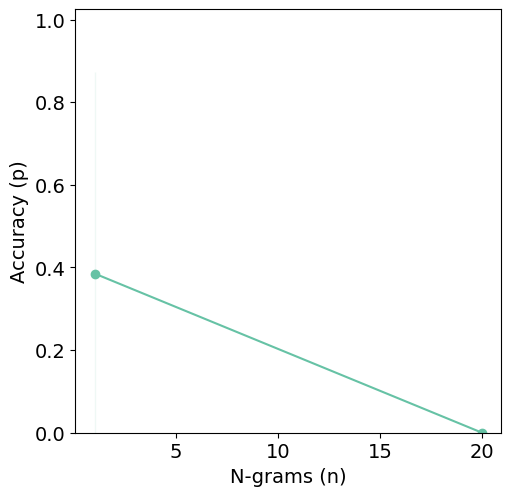

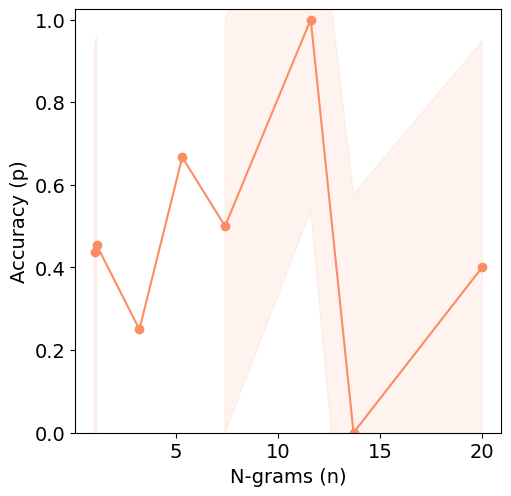

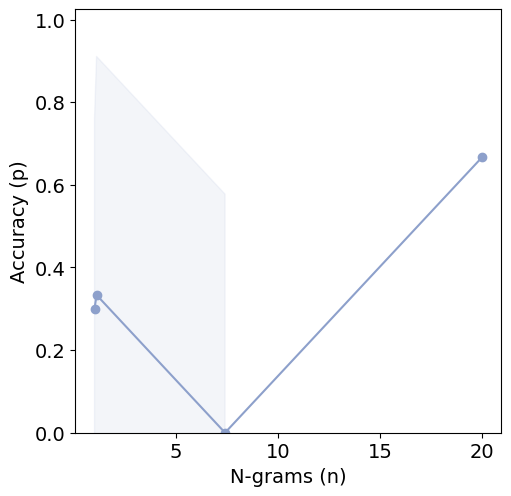

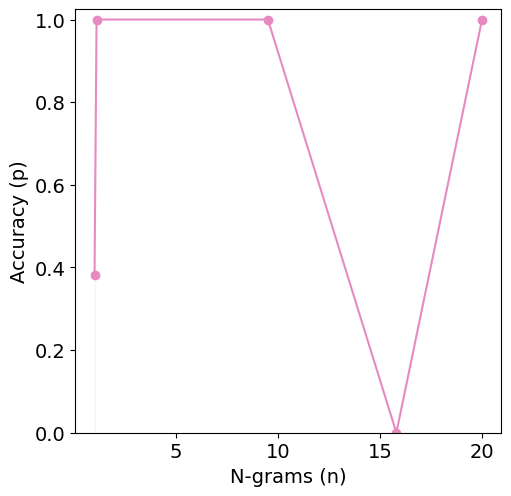

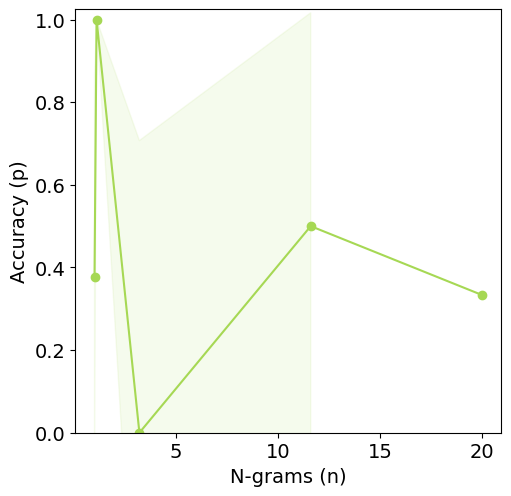

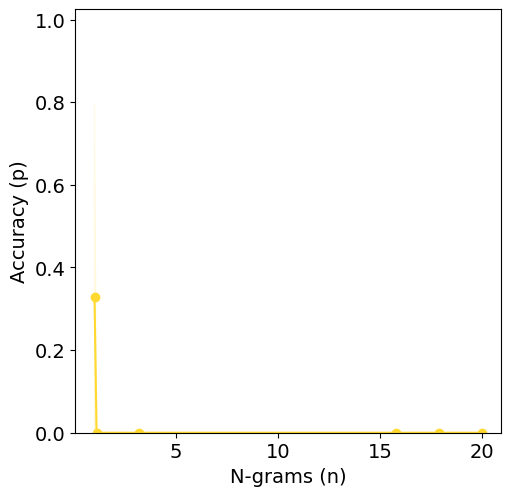

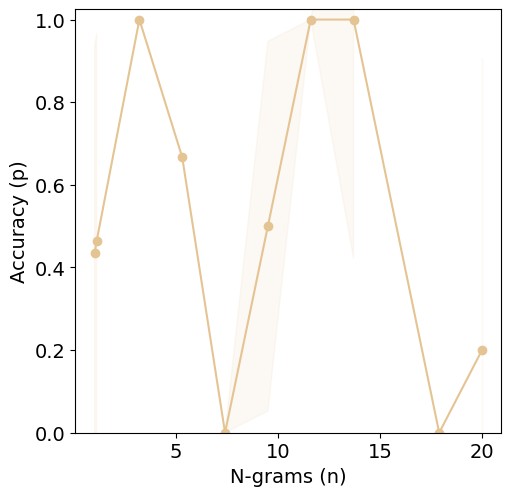

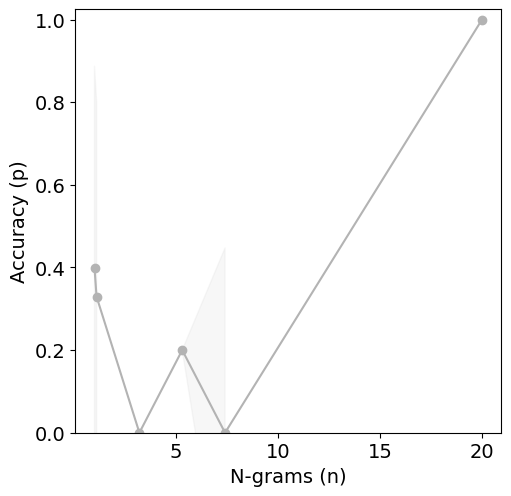

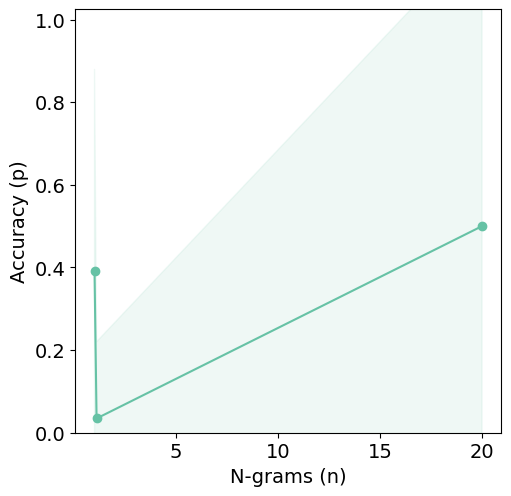

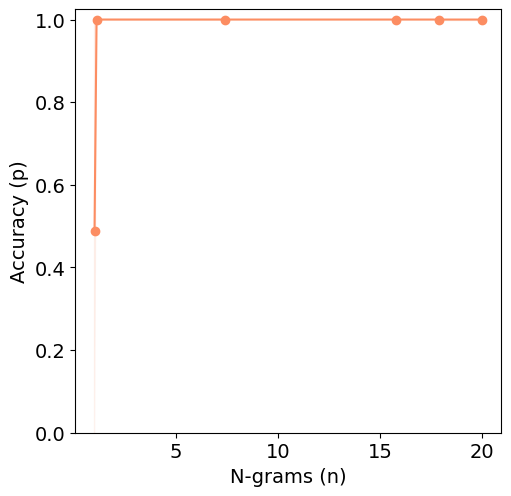

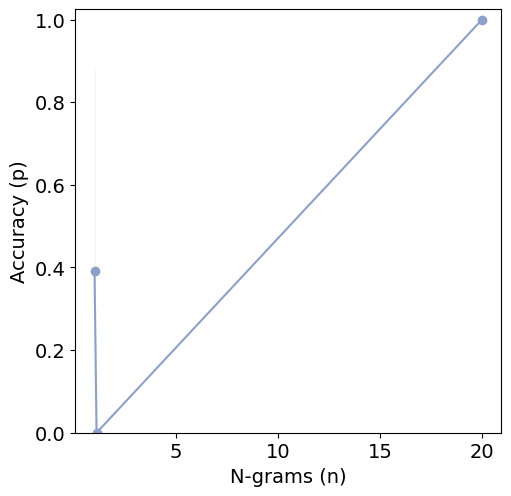

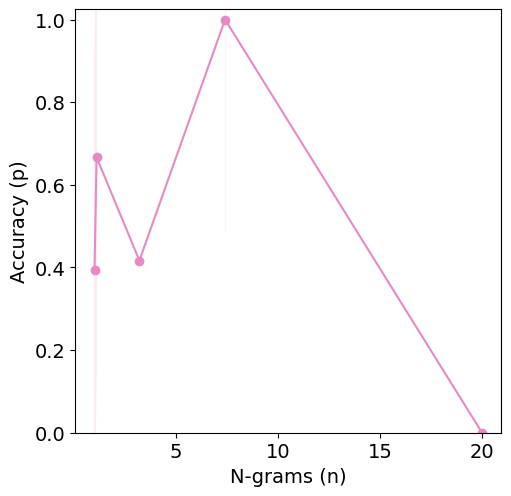

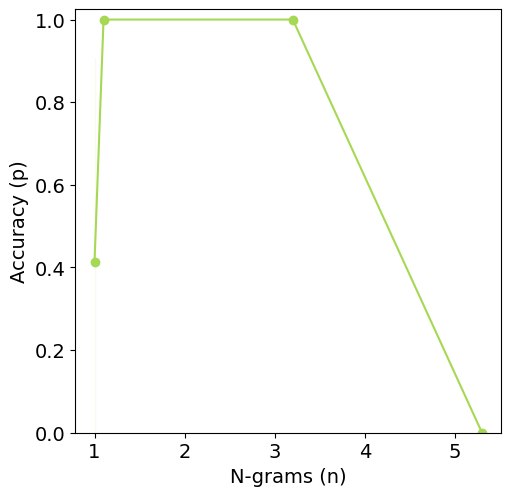

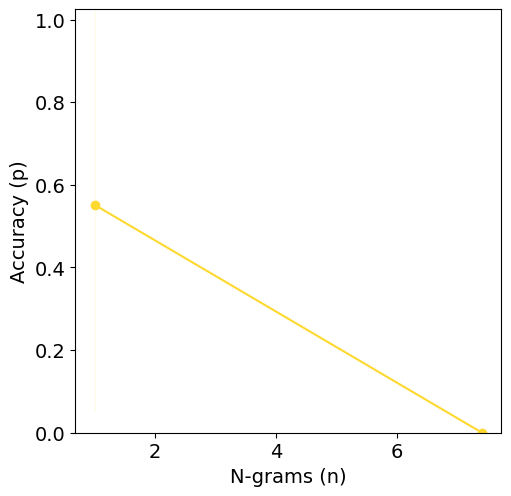

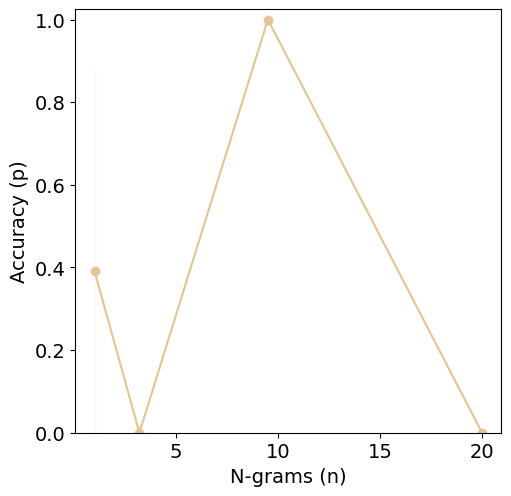

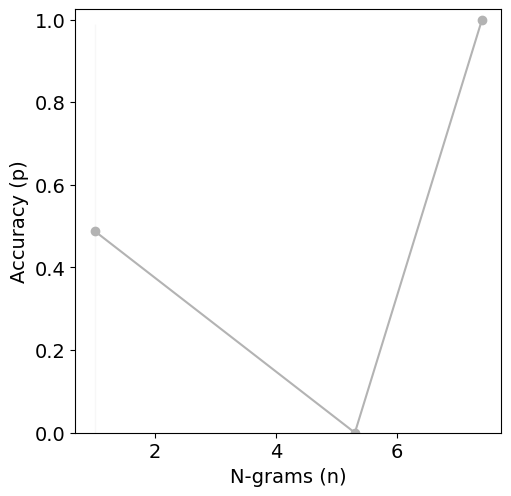

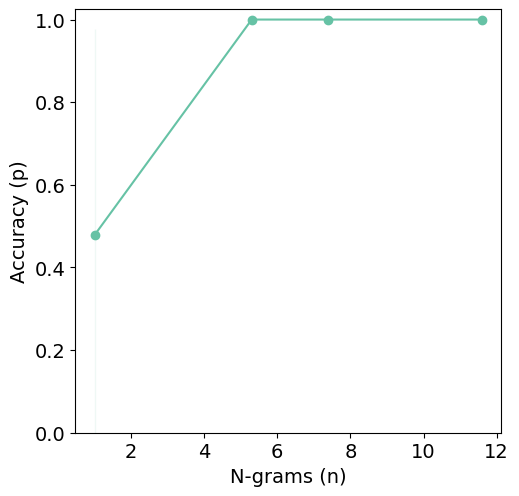

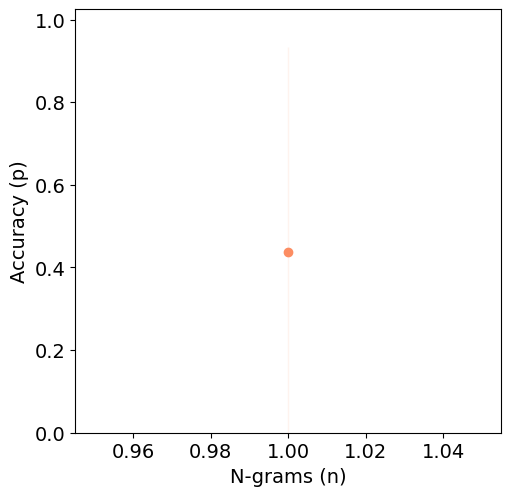

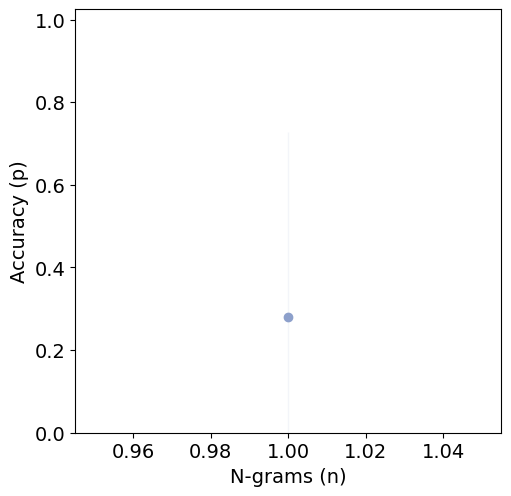

In [18]:
import numpy as np

# Define color palette
color_palette = sns.color_palette('Set2', len(examples_models_tasks))

is_log = False
plot_var = 'value'
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")

for i, (model_name, data) in enumerate(examples_models_tasks.items()):
    print(f"name: {model_name}")
    
    # if model_name not in subjects:
    #     continue
    
    # Calculate percentiles
    # data['percentile'] = data[plot_var].rank(pct=True) * 100
    # data['value'] = data[plot_var] / data[plot_var].sum()

    # Create bins based on percentiles
    data = an.create_bins(data, 'value', -1, 20, 10, is_log)
    
    # Plot the data using the new column for the x-axis
    ptqa.plot_variable_by_interval(data, log_axis=is_log,
                                        x_column='interval', y_column='accuracy',
                                        save_pth=savefile, ax=None, 
                                        color=color_palette[i], label=model_name,
                                        plot_std=True, ylimits=[0, 1.025])
    ax.legend()

# Add labels and legend
ax.set_xlabel('Percentile')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

In [19]:

column = 'value'
data['percentile'] = pd.qcut(data[column], q=n_bins, labels=False, duplicates='drop') + 1

NameError: name 'n_bins' is not defined

In [ ]:
data['percentile'].unique()

In [ ]:
question = "What is the medical term for high blood pressure?"
df_q = examples_model[examples_model['question'] == question]
df_q['Q']

In [ ]:
# from src.utils import normalize_string

# # Apply the function to each row of the DataFrame
# # examples_model[['q_coverage', 'a_coverage']] = examples_model.apply(calculate_qa_coverage, axis=1)

# coverage_df = an.calculate_qa_coverage(examples_model)

# coverage_df['q_coverage'].unique()

# coverage_df[coverage_df['q_coverage'] < 0]

In [ ]:
is_log = False
plot_var = 'q_coverage'
x_label = 'Question Coverage (p)'

examples_model_cov_int = an.create_bins(coverage_df, plot_var, 
                                        -0.1, 1.0, 5, 
                                        is_log=is_log)

ptqa.plot_variable_by_interval(examples_model_cov_int, log_axis=is_log,
                                x_column='interval', y_column='em',
                                save_pth=savefile, 
                                label='pythia-12b',
                                title=f'Performance vs. {plot_var} for Different Models N={N_GRAMS}',
                                x_label=x_label, 
                                plot_std=True)